In [1]:
%load_ext autoreload
%autoreload 2
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "MIG-0bb056ed-239d-5614-a667-fd108c1880cf"
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml
from hydra.utils import instantiate
from PIL import Image
from torch.utils.data import DataLoader, Dataset

from br.models.compute_features import get_embeddings
from br.models.load_models import get_data_and_models
from br.models.save_embeddings import get_pc_loss, save_embeddings
from br.models.utils import get_all_configs_per_dataset

device = "cuda:0"

# Load data and models

In [2]:
# Set paths
os.chdir("/allen/aics/modeling/ritvik/projects/benchmarking_representations/")
save_path = "./test_npm1_perturb/"

In [3]:
# Get datamodules, models, runs, model sizes

dataset_name = "npm1_perturb"
batch_size = 2
debug = False
results_path = "/allen/aics/modeling/ritvik/projects/benchmarking_representations/configs/results/"
data_list, all_models, run_names, model_sizes = get_data_and_models(
    dataset_name, batch_size, results_path, debug
)

# Compute embeddings

In [7]:
# Save embeddings for each model

splits_list = ["train", "val", "test"]
meta_key = None
eval_scaled_img = [False] * 5
eval_scaled_img_params = [{}] * 5
loss_eval_list = [None] * 5
sample_points_list = [False] * 5
skew_scale = None
save_embeddings(
    save_path,
    data_list,
    all_models,
    run_names,
    debug,
    splits_list,
    device,
    meta_key,
    loss_eval_list,
    sample_points_list,
    skew_scale,
    eval_scaled_img,
    eval_scaled_img_params,
)

Processing train


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 359/359 [01:13<00:00,  4.88it/s]


Processing val


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:04<00:00,  1.19it/s]


Processing test


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 77/77 [01:06<00:00,  1.16it/s]


# Get embeddings

In [80]:
# Load model and embeddings
DATASET_INFO = get_all_configs_per_dataset(results_path)
run_names = None
all_ret, orig = get_embeddings(run_names, dataset_name, DATASET_INFO, save_path)
all_ret["well_position"] = "A0"  # dummy
all_ret["Assay_Plate_Barcode"] = "Plate0"  # dummy

In [81]:
all_ret['model'].unique()

array(['Classical_image_SDF', 'Classical_image_seg', 'SO3_image_SDF',
       'SO3_image_seg', 'SO3_pointcloud_SDF'], dtype=object)

# mAP and fraction retrieved calculation

In [82]:
# Compute mAP and fraction retrieved as described in Chandrasekaran 2024
import pandas as pd
from tqdm import tqdm

from br.chandrasekaran_et_al import utils


def get_featurecols(df):
    """returna  list of featuredata columns"""
    return [c for c in df.columns if "mu" in c]


def get_featuredata(df):
    """return dataframe of just featuredata columns"""
    return df[get_featurecols(df)]


cols = [i for i in all_ret.columns if "mu" in i]

replicate_feature = "Metadata_broad_sample"
batch_size = 100000
null_size = 100000


all_rep = []
all_match = []
all_fr = []
for model in tqdm(all_ret["model"].unique(), total=len(all_ret["model"].unique())):
    df_feats = all_ret.loc[all_ret["model"] == model].reset_index(drop=True)
    df_feats["Metadata_ObjectNumber"] = df_feats["CellId"]

    import pycytominer

    all_normalized_df = []
    cols = [i for i in df_feats.columns if "mu" in i]
    for plate in df_feats["Assay_Plate_Barcode"].unique():
        test = df_feats.loc[df_feats["Assay_Plate_Barcode"] == plate].reset_index(drop=True)
        # test = test.groupby(['condition_coarse']).mean().reset_index()
        # test['Assay_Plate_Barcode'] = 'plate0'
        # test['well_position'] = 'a0'
        normalized_df = pycytominer.normalize(
            profiles=test,
            features=cols,
            meta_features=[
                "Assay_Plate_Barcode",
                "well_position",
                "condition_coarse",
                "condition",
            ],
            method="standardize",
            mad_robustize_epsilon=0,
            samples="all",
        )
        normalized_df = pycytominer.normalize(
            profiles=normalized_df,
            features=cols,
            meta_features=[
                "Assay_Plate_Barcode",
                "well_position",
                "condition_coarse",
                "condition",
            ],
            method="standardize",
            samples="condition == 'DMSO (control)'",
        )

        all_normalized_df.append(normalized_df)
    df_final = pd.concat(all_normalized_df, axis=0).reset_index(drop=True)

    vals = []
    for ind, row in df_final.iterrows():
        if row["condition"] == "DMSO (control)":
            vals.append("negcon")
        else:
            vals.append(None)

    # more dummy cols
    df_final["Metadata_control_type"] = vals
    df_final["Metadata_broad_sample"] = df_final["condition"]
    df_final["Cell_type"] = "hIPSc"
    df_final["Perturbation"] = "compound"
    df_final["Time"] = "1"
    df_final["Metadata_target_list"] = "none"
    df_final["target_list"] = "none"
    df_final["Metadata_Plate"] = "Plate0"

    experiment_df = df_final

    replicability_map_df = pd.DataFrame()
    replicability_fr_df = pd.DataFrame()
    matching_map_df = pd.DataFrame()
    matching_fr_df = pd.DataFrame()
    gene_compound_matching_map_df = pd.DataFrame()
    gene_compound_matching_fr_df = pd.DataFrame()

    replicate_feature = "Metadata_broad_sample"
    for cell in experiment_df.Cell_type.unique():
        cell_df = experiment_df.query("Cell_type==@cell")
        modality_1_perturbation = "compound"
        modality_1_experiments_df = cell_df.query("Perturbation==@modality_1_perturbation")
        for modality_1_timepoint in modality_1_experiments_df.Time.unique():
            modality_1_timepoint_df = modality_1_experiments_df.query(
                "Time==@modality_1_timepoint"
            )
            modality_1_df = pd.DataFrame()
            for plate in modality_1_timepoint_df.Assay_Plate_Barcode.unique():
                data_df = df_final.loc[df_final["Assay_Plate_Barcode"].isin([plate])]
                data_df = data_df.drop(
                    columns=["Metadata_target_list", "target_list"]
                ).reset_index(drop=True)
                # data_df = data_df.groupby(['pert_iname']).sample(n=10).reset_index(drop=True)
                modality_1_df = utils.concat_profiles(modality_1_df, data_df)

            # Set Metadata_broad_sample value to "DMSO" for DMSO wells
            modality_1_df[replicate_feature].fillna("DMSO", inplace=True)
            print(modality_1_df.shape)

            # Remove empty wells
            modality_1_df = utils.remove_empty_wells(modality_1_df)

            # Description
            description = f"{modality_1_perturbation}_{cell}_{utils.time_point(modality_1_perturbation, modality_1_timepoint)}"

            modality_1_df["Metadata_negcon"] = np.where(
                modality_1_df["Metadata_control_type"] == "negcon", 1, 0
            )  # Create dummy column

            pos_sameby = ["Metadata_broad_sample"]
            pos_diffby = []
            neg_sameby = ["Metadata_Plate"]
            neg_diffby = ["Metadata_negcon"]

            metadata_df = utils.get_metadata(modality_1_df)
            feature_df = get_featuredata(modality_1_df)
            feature_values = feature_df.values

            result = utils.run_pipeline(
                metadata_df,
                feature_values,
                pos_sameby,
                pos_diffby,
                neg_sameby,
                neg_diffby,
                anti_match=False,
                batch_size=batch_size,
                null_size=null_size,
            )
            result = result.query("Metadata_negcon==0").reset_index(drop=True)

            qthreshold = 0.001

            replicability_map_df, replicability_fr_df = utils.create_replicability_df(
                replicability_map_df,
                replicability_fr_df,
                result,
                pos_sameby,
                qthreshold,
                modality_1_perturbation,
                cell,
                modality_1_timepoint,
            )
    replicability_map_df["model"] = model
    matching_map_df["model"] = model
    replicability_fr_df["model"] = model
    all_rep.append(replicability_map_df)
    all_match.append(matching_map_df)
    all_fr.append(replicability_fr_df)

  0%|                                                                                                                          | 0/5 [00:00<?, ?it/s]

(1025, 522)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 20%|██████████████████████▊                                                                                           | 1/5 [00:18<01:14, 18.66s/it]

(1025, 522)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 40%|█████████████████████████████████████████████▌                                                                    | 2/5 [00:36<00:54, 18.24s/it]

(1025, 522)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 60%|████████████████████████████████████████████████████████████████████▍                                             | 3/5 [00:54<00:36, 18.00s/it]

(1025, 522)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████▏                      | 4/5 [01:11<00:17, 17.71s/it]

(1025, 522)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:29<00:00, 17.80s/it]


In [83]:
all_rep = pd.concat(all_rep, axis=0).reset_index(drop=True)
all_fr = pd.concat(all_fr, axis=0).reset_index(drop=True)

all_fr["metric"] = "Fraction retrieved"
all_fr["value"] = all_fr["fr"]
all_rep["metric"] = "Mean average precision"
all_rep["value"] = all_rep["mean_average_precision"]
metrics = pd.concat([all_fr, all_rep], axis=0).reset_index(drop=True)

plot_df = metrics.loc[metrics["metric"] == "Fraction retrieved"].reset_index(drop=True)

In [84]:
rep_dict = {'CNN_sdf_noalign_global': 'Classical_image_SDF', 'CNN_sdf_SO3_global': 'SO3_image_SDF', 
           'CNN_seg_noalign_global': 'Classical_image_seg', 'CNN_seg_SO3_global': 'SO3_image_seg', 
           'vn_so3': 'SO3_pointcloud_SDF'}
all_rep['model'] = all_rep['model'].replace(rep_dict)

In [85]:
plot_df

,Description,Modality,Cell,time,timepoint,fr,model,metric,value,Metadata_broad_sample,mean_average_precision,nlog10pvalue,q_value,nlog10qvalue,above_p_threshold,above_q_threshold
0,compound_hIPSc_long,compound,hIPSc,long,1,0.353,Classical_image_SDF,Fraction retrieved,0.353,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,compound_hIPSc_long,compound,hIPSc,long,1,0.118,Classical_image_seg,Fraction retrieved,0.118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,compound_hIPSc_long,compound,hIPSc,long,1,0.412,SO3_image_SDF,Fraction retrieved,0.412,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,compound_hIPSc_long,compound,hIPSc,long,1,0.118,SO3_image_seg,Fraction retrieved,0.118,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,compound_hIPSc_long,compound,hIPSc,long,1,0.412,SO3_pointcloud_SDF,Fraction retrieved,0.412,NaN,NaN,NaN,NaN,NaN,NaN,NaN


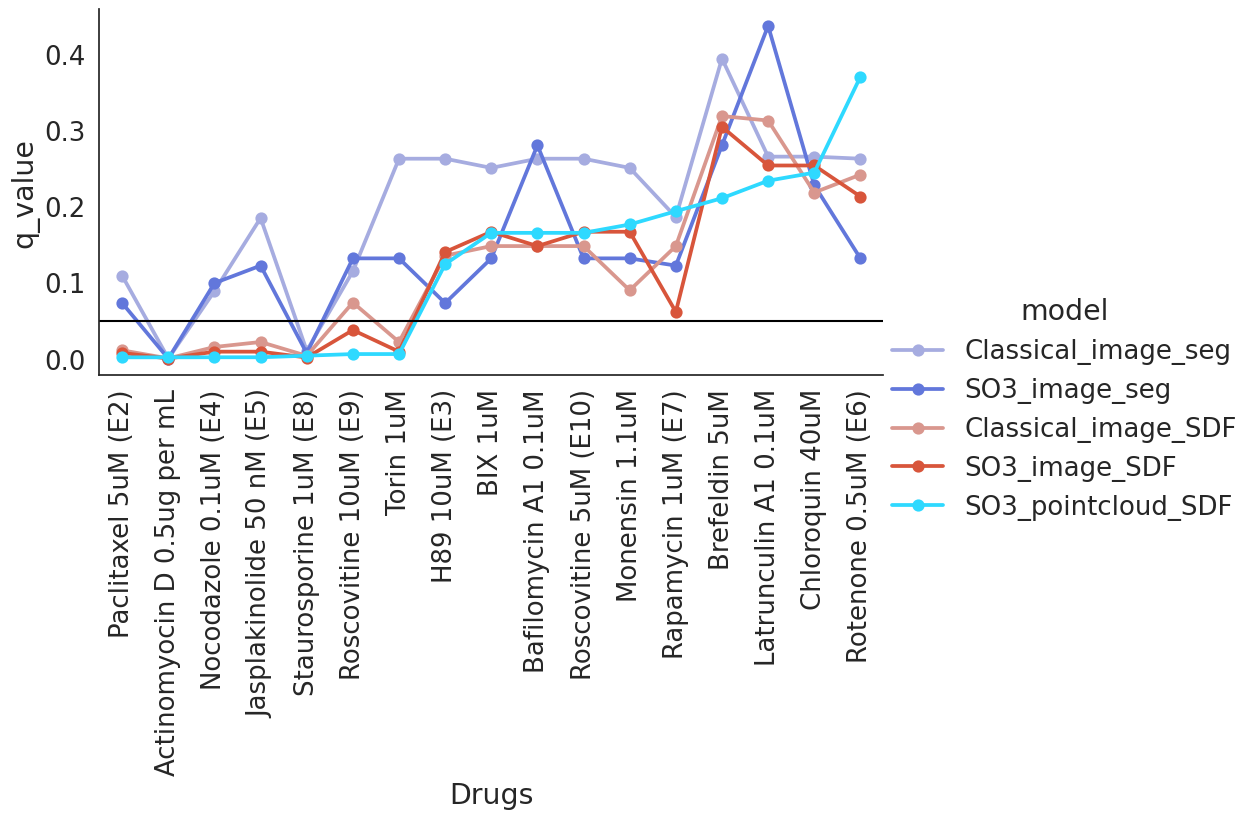

In [86]:
from pathlib import Path

import seaborn as sns

sns.set_context("talk")
sns.set(font_scale=1.7)
sns.set_style("white")

test = all_rep.sort_values(by="q_value").reset_index(drop=True)
test["Drugs"] = test["Metadata_broad_sample"]

x_order = (
    test.loc[test["model"] == "SO3_pointcloud_SDF"]
    .sort_values(by="q_value")["Metadata_broad_sample"]
    .values
)

g = sns.catplot(
    data=test,
    x="Drugs",
    y="q_value",
    hue="model",
    kind="point",
    order=x_order,
    hue_order=[
        "Classical_image_seg",
        "SO3_image_seg",
        "Classical_image_SDF",
        "SO3_image_SDF",
        "SO3_pointcloud_SDF",
    ],
    palette=["#A6ACE0", "#6277DB", "#D9978E", "#D8553B", "#2ED9FF"],
    aspect=2,
    height=5,
)
g.set_xticklabels(rotation=90)
plt.axhline(y=0.05, color="black")
this_path = Path(save_path + "drug_dataset")
Path(this_path).mkdir(parents=True, exist_ok=True)
#g.savefig(this_path / "q_values.pdf", dpi=300, bbox_inches="tight")

In [88]:
import pacmap
all_ = []
for model in all_ret['model'].unique():
    this_ = all_ret.loc[all_ret['model'] == model].reset_index(drop=True)
    cols = [i for i in all_ret.columns if "mu" in i]
    X = this_[cols].values
    embedding = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0) 
    X_transformed = embedding.fit_transform(X, init="pca")
    this_['PACMAP_1'] = X_transformed[:,0]
    this_['PACMAP_2'] = X_transformed[:,1]
    all_.append(this_)

In [89]:
all_ = pd.concat(all_, axis=0).reset_index(drop=True)

In [93]:
all_ = all_.loc[all_['model'] == 'SO3_pointcloud_SDF'].reset_index(drop=True)

In [94]:
all_['model'].unique()

array(['SO3_pointcloud_SDF'], dtype=object)

TypeError: kdeplot() takes from 0 to 1 positional arguments but 2 were given

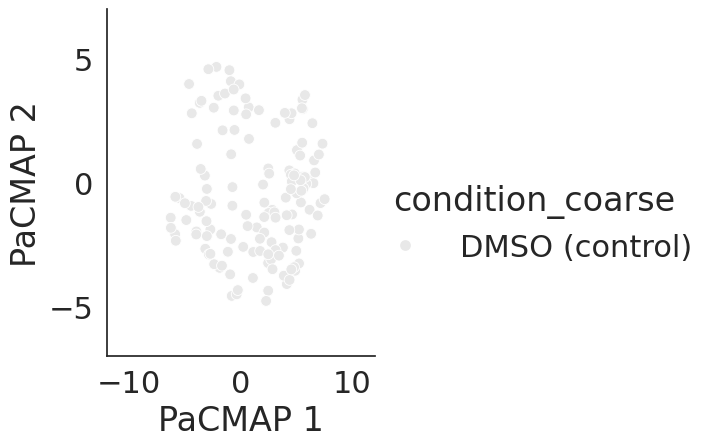

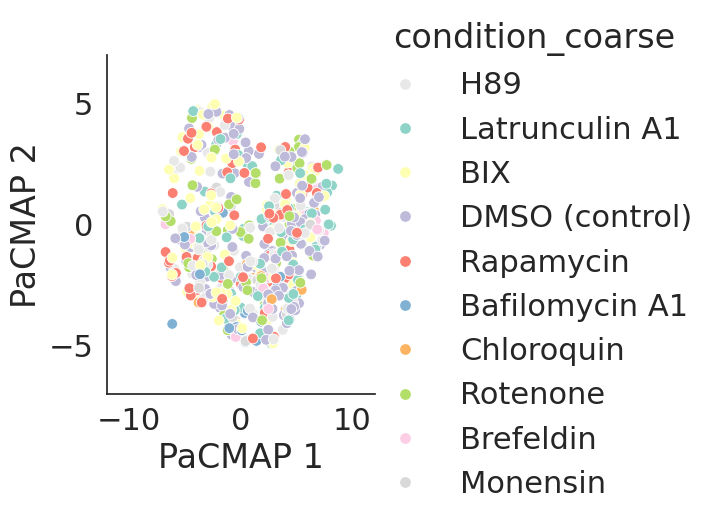

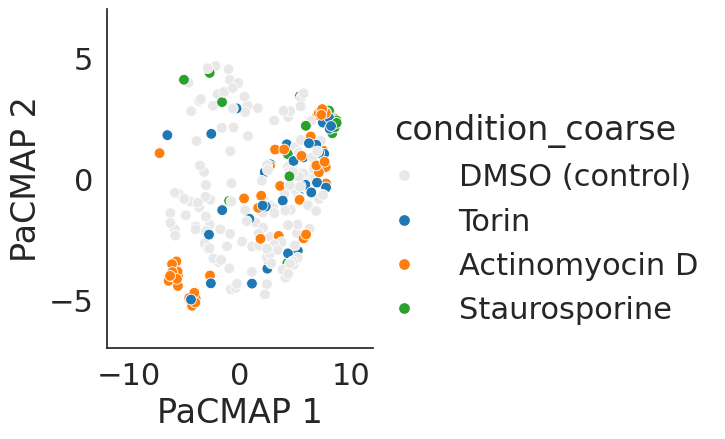

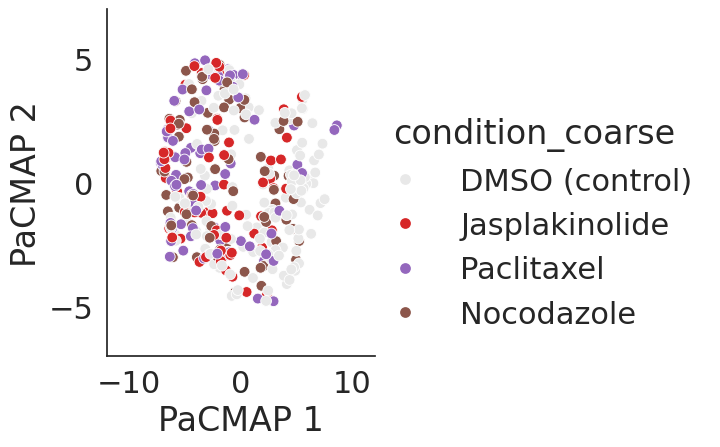

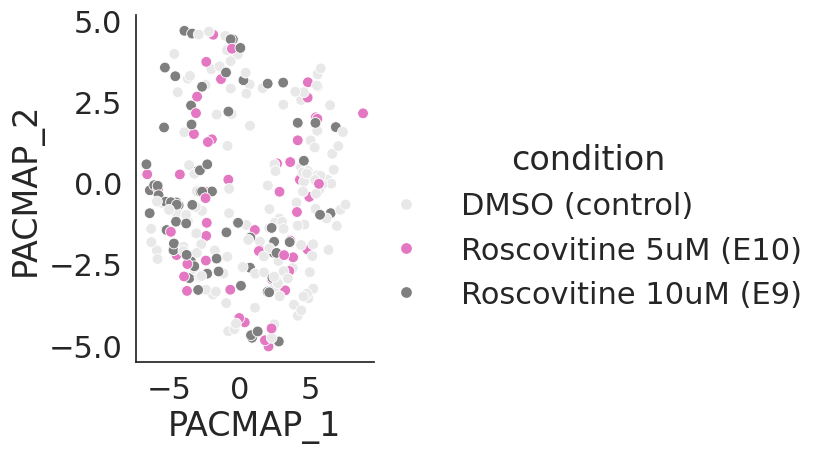

In [107]:
drugs_0 = ['DMSO (control)']
drugs_1 = ['DMSO (control)','Rotenone', 'BIX', 'Bafilomycin A1','Rapamycin', 'H89', 'Chloroquin', 
'Latrunculin A1', 'Brefeldin', 'Monensin']
drugs_2 = ['DMSO (control)', 'Actinomyocin D', 'Staurosporine', 'Torin']
drugs_3 = ['DMSO (control)', 'Paclitaxel', 'Jasplakinolide', 'Nocodazole']
drugs_4 = ['DMSO (control)', 'Roscovitine']

light_gray = sns.color_palette("gray", 10).as_hex()[-1]
colors_0 = sns.color_palette("gray", 10).as_hex()[-1:]
colors_1 = [light_gray] + sns.color_palette("Set3", 9).as_hex()
colors_2 = [light_gray] + sns.color_palette("tab10", 8).as_hex()[:3]
colors_3 = [light_gray] + sns.color_palette("tab10", 8).as_hex()[3:6]
colors_4 = [light_gray] + sns.color_palette("tab10", 8).as_hex()[6:]
colors = [colors_0, colors_1, colors_2, colors_3, colors_4]
for j, drugs in enumerate([drugs_0, drugs_1, drugs_2, drugs_3, drugs_4]):
    #drugs = ['DMSO (control)','Actinomyocin D', 'Staurosporine', 'Torin', 'Paclitaxel', 'Jasplakinolide', 'Nocodazole']
    plot = all_.loc[all_['condition_coarse'].isin(drugs)].reset_index(drop=True)
    this_c = colors[j]
    if 'Roscovitine' in drugs:
        # for jj, drug in enumerate(plot['condition'].unique()):
        #     this_plot = plot.loc[plot['condition'] == drug].reset_index(drop=True)  
        #     this_cc = this_c[jj]  
        #     import seaborn as sns
        #     sns.set_context('talk')
        #     g = sns.relplot(ax=ax, data=this_plot, x='PACMAP_1', y='PACMAP_2',  hue='condition', kind='scatter',palette=[this_cc], s=60)
        #     g.fig.axes[0].set_xlim([-12, 12])
        #     g.fig.axes[0].set_ylim([-7, 7])
        g = sns.relplot(ax=ax,data=plot, x='PACMAP_1', y='PACMAP_2',  hue='condition',hue_order=['DMSO (control)',
                                                                                          'Roscovitine 5uM (E10)',
                                                                                          'Roscovitine 10uM (E9)'], kind='scatter',palette=this_c, s=60, legend=True)
        g = sns.kdeplot(plot.PACMAP_1, plot.PACMAP_2)
        g.fig.axes[0].set_xlim([-12, 12])
        g.fig.axes[0].set_ylim([-7, 7])
    else:
        import seaborn as sns
        sns.set_context('talk')
        sns.set(font_scale=2)
        sns.set_style('white')
        g = sns.relplot(ax=ax, data=plot, x='PACMAP_1', y='PACMAP_2',  hue='condition_coarse', kind='scatter',palette=this_c, s=60, legend=True)
        g.fig.axes[0].set_xlim([-12, 12])
        g.fig.axes[0].set_ylim([-7, 7])
        g.fig.axes[0].set_xlabel('PaCMAP 1')
        g.fig.axes[0].set_ylabel('PaCMAP 2')


    # g.savefig(f'./drug_dataset/pacmap_drugs_{j}_leg.png', dpi=300, bbox_inches='tight')
    # g.savefig(f'./drug_dataset/pacmap_drugs_{j}_leg.pdf', dpi=300, bbox_inches='tight')

In [104]:
plot['condition'].unique()

array(['Roscovitine 10uM (E9)', 'DMSO (control)', 'Roscovitine 5uM (E10)'],
      dtype=object)

In [102]:
drugs

['DMSO (control)', 'Roscovitine']